## Data Acquisition

In this notebook, the required data for ego-noise prediction (enp) and aircraft classification is downloaded, and divided into a training, validation and test set with an approximate {0.6, 0.2, 0.2} split. <br><br>

### Ego-Noise Prediction
The enp data can be found in this reposity under _Mav.zip_. It consists of 14 pairs of MAV noise and flight data, which have been individually generated by the _ENP - Data Acquisition_ Notebook. Paparazzi UAV was used to communicate with the Parrot Bebop2 MAV, which powered a mounted Raspberry Pi fitted with a USB microphone. For each recording, the MAV traversed an indoor arena for 40-50 seconds by setting random waypoints to navigate to.  <br><br>

The following code snippet will unpack the set to the destination directory and split it into a training, validation and test set. It requires a user-defined root directory. All notebooks on this repository define the directory _Data_ in the parent directory of this repository as the root directory, i.e. :<br><br>

Notebook location: **my/path/aircraft_detector/Notebooks**<br>
Data location: **my/path/Data**<br>

Root directory has been set to '/home/mark/Documents/Thesis/Article/Data'.
Current directory is '/home/mark/Documents/Thesis/Article/aircraft_detector/Notebooks'.
Directory containing ENP audio data: '/home/mark/Documents/Thesis/Article/Data/Raw/Audio'.
Directory containing ENP flight data: '/home/mark/Documents/Thesis/Article/Data/Raw/States'.

Directory containing ENP Audio data for 'Train' set: '/home/mark/Documents/Thesis/Article/Data/Ego-Noise Prediction/Dataset/Train/Audio'.
Directory containing ENP States data for 'Train' set: '/home/mark/Documents/Thesis/Article/Data/Ego-Noise Prediction/Dataset/Train/States'.
Directory containing ENP Audio data for 'Val' set: '/home/mark/Documents/Thesis/Article/Data/Ego-Noise Prediction/Dataset/Val/Audio'.
Directory containing ENP States data for 'Val' set: '/home/mark/Documents/Thesis/Article/Data/Ego-Noise Prediction/Dataset/Val/States'.
Directory containing ENP Audio data for 'Test' set: '/home/mark/Documents/Thesis/Article/Data/Ego-Noise 

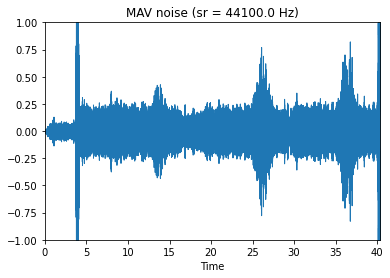

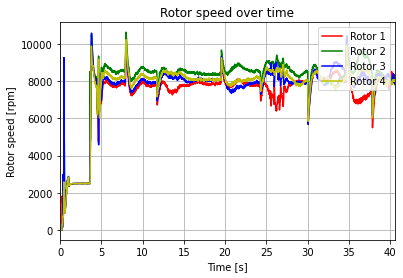

In [2]:
import os
import zipfile
import shutil

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import aircraft_detector.utils.plot_helper as ph


def extract_audio_data(dir_root, verbose=True, plot=True):
    if verbose:
        print("Root directory has been set to '%s'." % os.path.abspath(dir_root))
        print("Current directory is '%s'." % os.path.abspath(os.getcwd()))
    # Set the destination directory as the 'Raw' subdirectory
    dir_dest = os.path.join(dir_root, 'Raw')
    # make directory if it does not exist
    if not os.path.exists(dir_dest):
        os.makedirs(dir_dest)
        
    # set the filepath to the zipped file
    zipped_file = os.path.join(os.pardir, 'Mav.zip')
    # unpack the data
    with zipfile.ZipFile(zipped_file, 'r') as zip_ref:
        zip_ref.extractall(dir_dest)
    if verbose:
        print("Directory containing ENP audio data: '%s'." 
              % os.path.abspath(os.path.join(dir_dest, 'Audio')))
        print("Directory containing ENP flight data: '%s'." 
              % os.path.abspath(os.path.join(dir_dest, 'States')))
        print()
    
    # Get list of filenames
    files_audio = [os.path.join(dir_dest, 'Mav', 'Audio', f) 
                   for f in sorted(os.listdir(os.path.join(dir_dest, 'Mav', 'Audio')))]
    files_states = [os.path.join(dir_dest, 'Mav', 'States', f) 
                   for f in sorted(os.listdir(os.path.join(dir_dest, 'Mav', 'States')))]
    
    if plot:
        # Plot the first pair
        colors = ["orangered", "darkolivegreen", "steelblue", "goldenrod"]
        plt.figure()
        ph.plot_audio(files_audio[0], 44100)
        plt.figure()
        ph.plot_states_raw(files_states[0], 'rpm', colors)
    
    # Split the unpacked data into a training, validation and test set
    train_test_ratio = 0.8
    train_val_ratio = 0.8
    audio_train, audio_test, states_train, states_test = train_test_split(
        files_audio, files_states, train_size=train_test_ratio, random_state=42)
    audio_train, audio_val, states_train, states_val = train_test_split(
        audio_train, states_train, train_size=train_val_ratio, random_state=42)
    
    # Group the files
    files_train = [audio_train, states_train]
    files_val = [audio_val, states_val]
    files_test = [audio_test, states_test]
    files = [files_train, files_val, files_test]
    
    # Set the root directory for outputting the split data
    dir_root_out = os.path.join(dir_root, 'Ego-Noise Prediction', 'Dataset')
    # Copypaste files
    for i, subset in enumerate(['Train', 'Val', 'Test']):
        for j, data in enumerate(['Audio', 'States']):
            # Output directory for subset, data
            dir_dest = os.path.join(dir_root_out, subset, data)
            if not os.path.exists(dir_dest):
                os.makedirs(dir_dest)
            # Copy to destination
            for f in files[i][j]:
                shutil.copy(f, dir_dest)
            if verbose:
                print("Directory containing ENP %s data for '%s' set: '%s'."
                     % (data, subset, os.path.abspath(dir_dest)))
                
# assign root directory
root_directory = os.path.join(os.pardir, os.pardir, 'Data')
extract_audio_data(root_directory)

### Aircraft Classification
The data for aircraft classification is a subset of the full ESC-50 dataset found at https://github.com/karoldvl/ESC-50/, which contains 50 categories with 40 five-second recordings per category.<br><br>

The subset is obtained by extracting only categories relevant to aircraft detection from the ESC-50 set. For aircraft detection using an in-flight MAV, only the categories _airplane_, _engine_, _helicopter_, _train_ and _wind_ are deemed relevant.<br><br>

This dataset is then split up into a training, validation and test set, with an approximate split of {0.64. 0.16, 0.20} between sets _per category_. In other words, the training set will contain 25 (out of 40) airplane examples, the validation set will contain 7 airplane examples, and the test set will contain 8 airplane examples. The same division holds for the other categories. <br><br>

Finally, three types of data augmentation are used to augment the training data: 
- pitch shifting the audio by {-2, -1, 1, 2} octaves
- stretching/compressing the audio by {0.70, 0.85, 1.15, 1.30}
- mixing audio within the same class, four times  <br><br>

Using the __DataAcquisition__ class, the following code snippet performs the steps describes above. Note that the root directory (defined in the cell above) must be supplied to the class.

ESC-50 has already been extracted to /home/mark/Documents/Thesis/Article/Data/Raw/Aircraft/ESC-50-master.zip
Finished exporting 200 files (sr = 44100 Hz)
Finished generating 40 instances of silence.
Split per category (Train, Val, Test): (25, 7, 8)


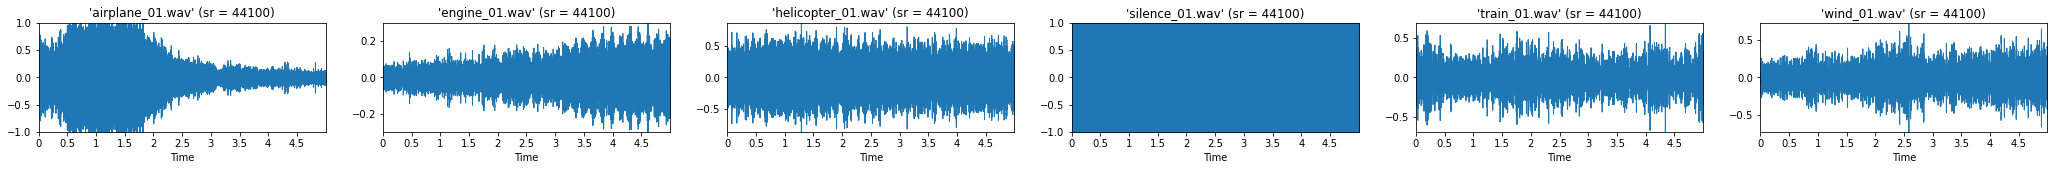

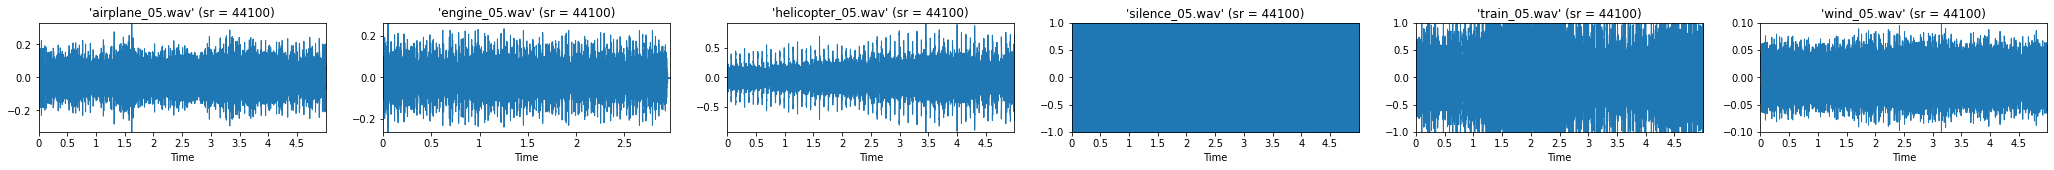

In [2]:
import aircraft_detector.aircraft_classification.data_acquisition as da


acquisition = da.DataAcquisition(dir_root)

# download the ESC-50 set (600MB download, approx. 900MB unzipped), may take 5-10 minutes
acquisition.import_audio_esc50()

# extract the subset
categories = ['airplane', 'engine', 'helicopter', 'train', 'wind']
acquisition.extract_audio_from_esc50(categories)

# split the dataset
acquisition.split_dataset()

# extract the augmentations: class mix x4, pitch shift x4, time stretch x4
acquisition.augment_training_data()

# plot some examples
acquisition.plot_examples('Train')
acquisition.plot_examples('Test')